In [1]:
import itertools
import logging
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

## Data Ingestion

In [3]:
data_dir = 'data'
img_path = os.path.join(data_dir, 'selva_2.png')

cell_number = 5

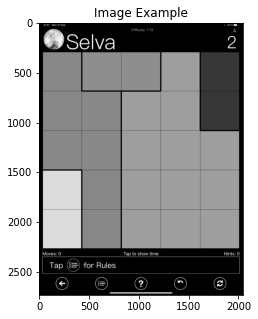

In [4]:
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(16, 5))
plt.imshow(img, cmap='gray')
_ = plt.title('Image Example')

## Image Preprocessing

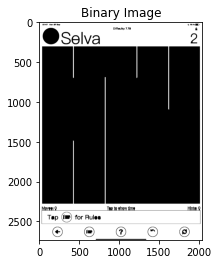

In [5]:
threshold, img_binary = cv2.threshold(img, 10, 120, cv2.THRESH_BINARY_INV)
img_binary = cv2.morphologyEx(img_binary, cv2.MORPH_OPEN, (13, 13), iterations=13) 

plt.imshow(img_binary, cmap='gray')
_ = plt.title('Binary Image')

## Contour Detection

In [6]:
def get_longest_contour(contours):
    if not contours:
        return
    longest_contour = contours[0]
    for c in contours:
        if len(longest_contour) <= len(c):
            longest_contour = c
    return longest_contour

In [7]:
# for i, c in enumerate(contours):
#     print(i, len(c))

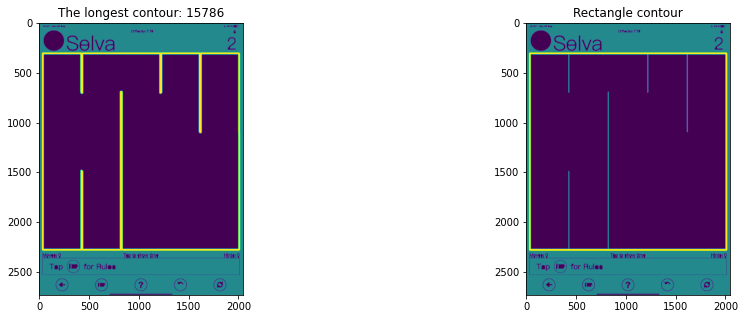

In [8]:
contours, hierarchy = cv2.findContours(image=img_binary, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
longest_contour = get_longest_contour(contours)

image_contour = img_binary.copy()
image_recangle = img_binary.copy()

cv2.drawContours(image=image_contour, contours=longest_contour, 
                 contourIdx=-1, color=(255, 0, 0), thickness=20, lineType=cv2.LINE_4)

x, y, w, h = cv2.boundingRect(longest_contour)
cv2.rectangle(image_recangle, (x, y), (x + w, y + h), color=(255, 255, 0), thickness=20, 
                              lineType=cv2.FILLED)
_, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
ax.imshow(image_contour)
ax.set_title(f'The longest contour: {len(longest_contour)}')

ax = axs[1]
ax.imshow(image_recangle)
_ = ax.set_title('Rectangle contour')

## Shapes Detection

### Shapes Contour Detection

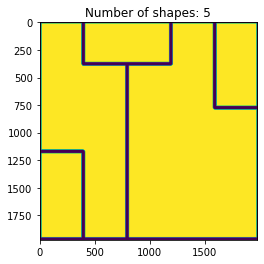

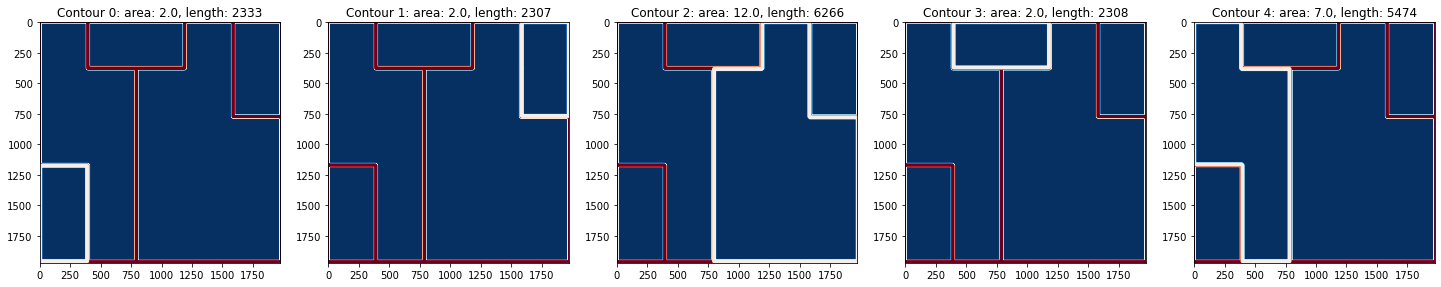

In [9]:
img_cropped = img[y:y+h, x:x+w]
img_binary_cropped = img_cropped.copy()
threshold, img_binary_cropped = cv2.threshold(img_cropped, 0, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(image=img_binary_cropped, mode=cv2.RETR_TREE, 
                                       method=cv2.CHAIN_APPROX_NONE)

_ = cv2.drawContours(image=img_binary_cropped, contours=contours, 
                 contourIdx=-1, color=(0, 255, 0), thickness=20, lineType=cv2.LINE_4)
plt.imshow(img_binary_cropped)
plt.title(f'Number of shapes: {len(contours)}')

_, axs = plt.subplots(1, cell_number, figsize=(5 * cell_number, cell_number))
for i, c in enumerate(contours):
    area = cv2.contourArea(c)
    img_temp = img_binary_cropped.copy()
    cv2.drawContours(image=img_temp, contours=c, 
                 contourIdx=-1, color=(120, 120, 0), thickness=30, lineType=cv2.LINE_AA)
    axs[i].imshow(img_temp, cmap='RdBu')
    axs[i].set_title(f'Contour {i}: area: {area // 144244}, length: {len(c)}')

### Shapes Parsing

In [10]:
def get_shapes_df(img_binary_cropped, contours):
    square_contour = []

    img_height, img_width = img_binary_cropped.shape
    rect_height, rect_width = img_height // cell_number, img_width // cell_number
    for i in range(0, cell_number):
        for j in range(0, cell_number):
            x = rect_width * i + rect_width // 2
            y = rect_height * j + rect_height // 2
            for c_num, c in enumerate(contours):
                result = cv2.pointPolygonTest(c, (x, y), False) 
                if result == 1:
                    square_contour.append({'x': i, 'y': j, 'contour': c_num})
    df_squares = pd.DataFrame(square_contour)
    return df_squares

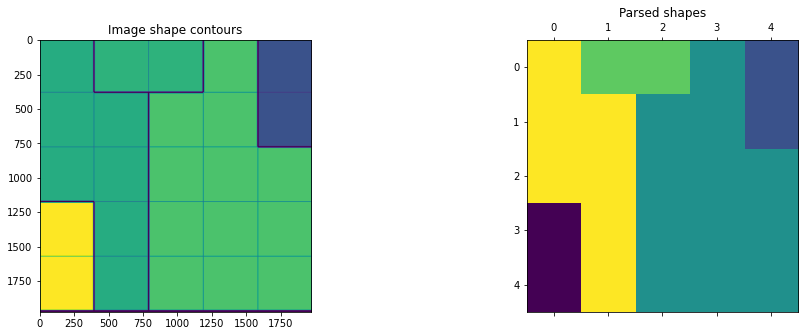

In [11]:
df_squares = get_shapes_df(img_binary_cropped, contours)

_, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].imshow(img_cropped)
axs[0].set_title('Image shape contours')

axs[1].matshow(df_squares['contour'].values.reshape(cell_number, cell_number).T)
_ = axs[1].set_title('Parsed shapes')

## Solution

In [12]:
def if_solution_has_trees_on_same_axis(solution):
    for i, tree1 in enumerate(solution):
        for j, tree2 in enumerate(solution):
            if i <= j:
                continue
            x1, y1 = tree1
            x2, y2 = tree2
            if x1 == x2 or y1 == y2:
                return True
            if abs(x2 - x1) == 1 and abs(y2 - y1) == 1:
                return True
        
    return False

def is_solution_correct(df_board, solution):
    if if_solution_has_trees_on_same_axis(solution):
        logger.debug('Trees on the same axis %s', solution)
        return False
    for i, tree1 in enumerate(solution):
        for j, tree2 in enumerate(solution):
            if i <= j:
                continue
            
            cnt1 = df_board.query(f'x == {tree1[0]} and y == {tree1[1]}')['contour'].values[0]
            cnt2 = df_board.query(f'x == {tree2[0]} and y == {tree2[1]}')['contour'].values[0]
            if cnt1 == cnt2:
                logger.debug('Trees in the same contour %s', cnt1)
                return False
    return True

In [23]:
logger.info('Brute force solution ')
correct_solutions = []
all_possible_solutions1 = itertools.permutations(range(0, cell_number))
all_possible_solutions2 = itertools.permutations(range(0, cell_number))
for i, sol1 in enumerate(all_possible_solutions1):
    for j, sol2 in enumerate(all_possible_solutions2):
        if j <= i:
            continue
        sol = list(zip(sol1, sol2))
        if is_solution_correct(df_squares, sol):
            logger.info('Correct solution %s', sol)
            correct_solutions.append(sol)
logger.info('There is %s solutions', len(correct_solutions))

2021-10-15 14:56:28,254 - INFO - Correct solution [(0, 4), (1, 2), (2, 0), (3, 3), (4, 1)]
2021-10-15 14:56:28,255 - INFO - There is 1 solutions


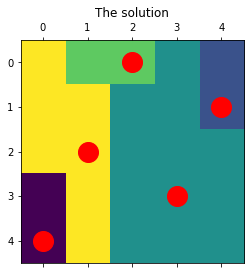

In [20]:
correct_solution = correct_solutions[0]
plt.matshow(df_squares['contour'].values.reshape(cell_number, cell_number).T)
xs, ys = list(zip(*correct_solution))
plt.plot(xs, ys, marker='o', c='r',linestyle='None', markersize=20)
_ = plt.title('The solution')